# Required libraries

In [8]:
import pandas as pd
import numpy as np
import re
import string
import sys
import time
import nltk
from nltk.corpus import reuters
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from gensim.models import Word2Vec
from collections import Counter, defaultdict
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix, classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
!pip install gensim nltk scikit-learn matplotlib seaborn wordcloud
!python -m nltk.downloader reuters punkt stopwords
print("All libraries imported successfully!")
print("Python version:", sys.version)

<frozen runpy>:128: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
[nltk_data] Downloading package reuters to /root/nltk_data...
[nltk_data]   Package reuters is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
All libraries imported successfully!
Python version: 3.11.13 (main, Jun  4 2025, 08:57:29) [GCC 11.4.0]


# Problem 01:

Download the IMDB movie review dataset and preprocess the text by tokenizing, converting it to lowercase, and removing punctuation. Next, apply a TF-IDF vectorizer (sklearn.feature_extraction.text.TfidfVectorizer) to transform the corpus into TF-IDF embeddings. Split the dataset into 70% training and 30% testing data, ensuring stratification. Train a Logistic Regression model using the scikit-learn library and evaluate its performance by computing the F1 score. Report the confusion matrix along with the classification report.

## Problem 01: Load the Dataset & EDA

In [9]:
print("=== STEP 2: Loading IMDB Dataset ===")
# Upload the dataset file to Colab
dataset_path = '/content/drive/MyDrive/440/IMDB Dataset.csv'

# Load the dataset
df = pd.read_csv(dataset_path)
print(f"Dataset shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
print("\nFirst 5 rows:")
print(df.head())

# Check for missing values
print(f"\nMissing values:\n{df.isnull().sum()}")

# Check class distribution
print(f"\nClass distribution:\n{df['sentiment'].value_counts()}")


=== STEP 2: Loading IMDB Dataset ===
Dataset shape: (50000, 2)
Columns: ['review', 'sentiment']

First 5 rows:
                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive

Missing values:
review       0
sentiment    0
dtype: int64

Class distribution:
sentiment
positive    25000
negative    25000
Name: count, dtype: int64


## Problem 01: Text Preprocessing

In [10]:
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()

    # Remove HTML tags (common in IMDB reviews)
    text = re.sub(r'<.*?>', '', text)

    # Remove URLs
    text = re.sub(r'http\S+', '', text)

    # Remove punctuation and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Remove extra whitespaces
    text = ' '.join(text.split())

    return text

# Apply preprocessing to the reviews
print("Preprocessing text data...")
df['processed_review'] = df['review'].apply(preprocess_text)

# Display preprocessing results
print("\nOriginal vs Processed examples:")
for i in range(2):
    print(f"\nExample {i+1}:")
    print(f"Original: {df['review'].iloc[i][:200]}...")
    print(f"Processed: {df['processed_review'].iloc[i][:200]}...")


Preprocessing text data...

Original vs Processed examples:

Example 1:
Original: One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me abo...
Processed: one of the other reviewers has mentioned that after watching just oz episode youll be hooked they are right as this is exactly what happened with methe first thing that struck me about oz was its brut...

Example 2:
Original: A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece...
Processed: a wonderful little production the filming technique is very unassuming very oldtimebbc fashion and gives a comforting and sometimes discomforting sense of realism to the entire piece the actors are ex...


## Problem 01: Prepare Data for Model Training

In [11]:
# Extract features (X) and labels (y)
X = df['processed_review']
y = df['sentiment'].map({'positive': 1, 'negative': 0})  # Convert to binary

print(f"Feature vector length: {len(X)}")
print(f"Label distribution after encoding:\n{y.value_counts()}")

# Step 5: Train-Test Split with Stratification
print("\n=== STEP 5: Train-Test Split ===")

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,           # 30% for testing
    random_state=42,         # For reproducibility
    stratify=y               # Maintain class distribution
)

print(f"Training set size: {len(X_train)}")
print(f"Testing set size: {len(X_test)}")
print(f"Training set class distribution:\n{y_train.value_counts()}")
print(f"Testing set class distribution:\n{y_test.value_counts()}")


Feature vector length: 50000
Label distribution after encoding:
sentiment
1    25000
0    25000
Name: count, dtype: int64

=== STEP 5: Train-Test Split ===
Training set size: 35000
Testing set size: 15000
Training set class distribution:
sentiment
1    17500
0    17500
Name: count, dtype: int64
Testing set class distribution:
sentiment
0    7500
1    7500
Name: count, dtype: int64


## Problem 01: TF-IDF Vectorization

In [12]:
# Initialize TF-IDF Vectorizer with optimized parameters
tfidf_vectorizer = TfidfVectorizer(
    max_features=10000,      # Limit vocabulary size for efficiency
    stop_words='english',    # Remove common English stop words
    ngram_range=(1, 2),      # Use unigrams and bigrams
    min_df=2,                # Ignore terms that appear in less than 2 documents
    max_df=0.95              # Ignore terms that appear in more than 95% of documents
)

# Fit and transform training data
print("Fitting TF-IDF vectorizer on training data...")
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

# Transform test data
print("Transforming test data...")
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print(f"TF-IDF matrix shape (train): {X_train_tfidf.shape}")
print(f"TF-IDF matrix shape (test): {X_test_tfidf.shape}")
print(f"Vocabulary size: {len(tfidf_vectorizer.vocabulary_)}")


Fitting TF-IDF vectorizer on training data...
Transforming test data...
TF-IDF matrix shape (train): (35000, 10000)
TF-IDF matrix shape (test): (15000, 10000)
Vocabulary size: 10000


## Problem 01: Model Training

In [13]:
# Initialize Logistic Regression model
lr_model = LogisticRegression(
    random_state=42,         # For reproducibility
    max_iter=1000,           # Increase iterations for convergence
    solver='liblinear'       # Good solver for this problem size
)

# Train the model
print("Training Logistic Regression model...")
lr_model.fit(X_train_tfidf, y_train)

print("Model training completed!")
print(f"Model coefficients shape: {lr_model.coef_.shape}")
print(f"Model intercept: {lr_model.intercept_}")

Training Logistic Regression model...
Model training completed!
Model coefficients shape: (1, 10000)
Model intercept: [0.03181588]


## Problem 01: Model Prediction and Evaluation

In [14]:
# Make predictions on test set
y_pred = lr_model.predict(X_test_tfidf)

# Calculate F1 Score
f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1:.4f}")

# Generate Classification Report
print("\nClassification Report:")
class_report = classification_report(y_test, y_pred, target_names=['Negative', 'Positive'])
print(class_report)

# Calculate and Display Confusion Matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)


F1 Score: 0.8931

Classification Report:
              precision    recall  f1-score   support

    Negative       0.90      0.88      0.89      7500
    Positive       0.88      0.90      0.89      7500

    accuracy                           0.89     15000
   macro avg       0.89      0.89      0.89     15000
weighted avg       0.89      0.89      0.89     15000


Confusion Matrix:
[[6599  901]
 [ 721 6779]]


## Problem 01: Visualization

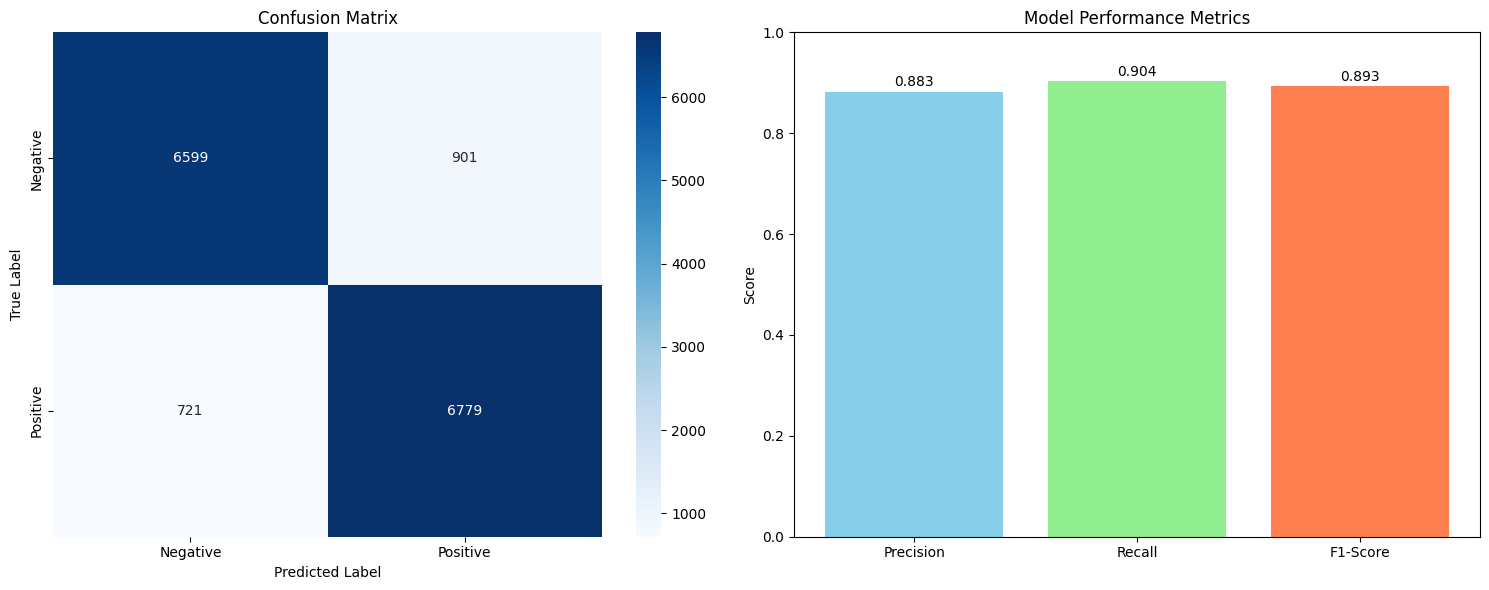

In [15]:
# Create figure with subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Confusion Matrix Heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'],
            ax=axes[0])
axes[0].set_title('Confusion Matrix')
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('True Label')

# Plot 2: Performance Metrics Bar Chart
metrics = ['Precision', 'Recall', 'F1-Score']
# Calculate metrics for positive class
from sklearn.metrics import precision_score, recall_score
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
values = [precision, recall, f1]

axes[1].bar(metrics, values, color=['skyblue', 'lightgreen', 'coral'])
axes[1].set_title('Model Performance Metrics')
axes[1].set_ylabel('Score')
axes[1].set_ylim(0, 1)

# Add value labels on bars
for i, v in enumerate(values):
    axes[1].text(i, v + 0.01, f'{v:.3f}', ha='center')

plt.tight_layout()
plt.show()

## Problem 01: Feature Analysis

In [16]:
feature_names = tfidf_vectorizer.get_feature_names_out()

# Get coefficients (weights) for each feature
coefficients = lr_model.coef_[0]

# Create feature importance dataframe
feature_importance = pd.DataFrame({
    'feature': feature_names,
    'coefficient': coefficients
})

# Sort by absolute coefficient value
feature_importance['abs_coef'] = np.abs(feature_importance['coefficient'])
feature_importance = feature_importance.sort_values('abs_coef', ascending=False)

# Display top positive and negative features
print("Top 10 Most Positive Features (indicating positive sentiment):")
top_positive = feature_importance.nlargest(10, 'coefficient')
print(top_positive[['feature', 'coefficient']])

print("\nTop 10 Most Negative Features (indicating negative sentiment):")
top_negative = feature_importance.nsmallest(10, 'coefficient')
print(top_negative[['feature', 'coefficient']])

Top 10 Most Positive Features (indicating positive sentiment):
        feature  coefficient
3788      great     6.924499
2845  excellent     6.503340
748        best     5.348076
6566    perfect     5.161511
284     amazing     4.857196
9829  wonderful     4.610800
5317      loved     4.473919
3501        fun     4.251170
4089  hilarious     4.167846
3045   favorite     4.138622

Top 10 Most Negative Features (indicating negative sentiment):
       feature  coefficient
9872     worst    -9.129192
556      awful    -7.559743
580        bad    -7.526873
9643     waste    -6.895207
921     boring    -5.968244
6767      poor    -5.768928
8885  terrible    -5.347464
9870     worse    -5.295167
4185  horrible    -5.071830
6771    poorly    -4.799623


## Problem 01: Model Testing with Custom Reviews

In [17]:
def predict_sentiment(review_text):
    """
    Predict sentiment for a custom review

    Args:
        review_text (str): Raw review text

    Returns:
        tuple: (prediction, probability)
    """
    # Preprocess the text
    processed_text = preprocess_text(review_text)

    # Transform using fitted TF-IDF vectorizer
    text_tfidf = tfidf_vectorizer.transform([processed_text])

    # Make prediction
    prediction = lr_model.predict(text_tfidf)[0]
    probability = lr_model.predict_proba(text_tfidf)[0]

    return prediction, probability

# Test with sample reviews
test_reviews = [
    "This movie was absolutely amazing! Great acting and fantastic plot.",
    "Terrible movie. Waste of time. Poor acting and boring story.",
    "The movie was okay. Nothing special but not terrible either."
]

print("Testing custom reviews:")
for i, review in enumerate(test_reviews, 1):
    pred, prob = predict_sentiment(review)
    sentiment = "Positive" if pred == 1 else "Negative"
    confidence = max(prob)

    print(f"\nReview {i}: {review}")
    print(f"Predicted Sentiment: {sentiment}")
    print(f"Confidence: {confidence:.3f}")

Testing custom reviews:

Review 1: This movie was absolutely amazing! Great acting and fantastic plot.
Predicted Sentiment: Positive
Confidence: 0.972

Review 2: Terrible movie. Waste of time. Poor acting and boring story.
Predicted Sentiment: Negative
Confidence: 1.000

Review 3: The movie was okay. Nothing special but not terrible either.
Predicted Sentiment: Negative
Confidence: 0.983


## Problem 01: Summary Statistics

In [18]:
print("Final Summary:")
print(f"Dataset Size: {len(df)} reviews")
print(f"Training Accuracy: {lr_model.score(X_train_tfidf, y_train):.4f}")
print(f"Testing Accuracy: {lr_model.score(X_test_tfidf, y_test):.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Vocabulary Size: {len(feature_names)}")
print(f"Model Parameters: {lr_model.coef_.size}")


Final Summary:
Dataset Size: 50000 reviews
Training Accuracy: 0.9203
Testing Accuracy: 0.8919
F1 Score: 0.8931
Vocabulary Size: 10000
Model Parameters: 10000


# Problem 2:
Obtain the GloVe embeddings (glove.6B.100d.txt). Perform analogy tasks such as “Queen – Woman + Man” and check whether the resulting vector is closest to “King” using the GloVe embeddings.

## Problem 02: Load GloVe Embeddings

In [19]:
glove_file = '/content/drive/MyDrive/440/glove.6B.100d.txt'
def load_glove_embeddings(file_path):
    start_time = time.time()

    word_to_vec = {}
    vocab = []
    embedding_dim = None
    skipped_words = 0

    with open(file_path, 'r', encoding='utf-8') as f:
        for line_num, line in enumerate(f):
            try:
                # Split line into word and vector components
                values = line.strip().split()
                if len(values) < 2:  # Skip empty or malformed lines
                    continue

                word = values[0]
                vector_values = values[1:]

                # Set expected dimension from first valid line
                if embedding_dim is None:
                    embedding_dim = len(vector_values)
                    print(f"Expected embedding dimension: {embedding_dim}")

                # Skip words with incorrect dimensions
                if len(vector_values) != embedding_dim:
                    skipped_words += 1
                    continue

                # Convert to numpy array
                vector = np.array(vector_values, dtype=np.float32)

                # Validate that conversion was successful
                if vector.shape[0] != embedding_dim:
                    skipped_words += 1
                    continue

                word_to_vec[word] = vector
                vocab.append(word)

                # Progress indicator
                if (line_num + 1) % 50000 == 0:
                    print(f"Loaded {line_num + 1} lines, valid words: {len(vocab)}")

            except Exception as e:
                skipped_words += 1
                if line_num < 10:  # Show first few errors for debugging
                    print(f"Warning: Skipped line {line_num + 1}: {str(e)[:100]}")
                continue

    load_time = time.time() - start_time

    print(f"\nGloVe embeddings loaded successfully!")
    print(f"Vocabulary size: {len(vocab):,}")
    print(f"Embedding dimension: {embedding_dim}")
    print(f"Skipped words (dimension mismatch): {skipped_words}")
    print(f"Loading time: {load_time:.2f} seconds")

    return word_to_vec, vocab, embedding_dim

# Load the embeddings
word_to_vec, vocab, embedding_dim = load_glove_embeddings(glove_file)

Expected embedding dimension: 100
Loaded 50000 lines, valid words: 50000
Loaded 100000 lines, valid words: 100000
Loaded 150000 lines, valid words: 150000
Loaded 200000 lines, valid words: 200000

GloVe embeddings loaded successfully!
Vocabulary size: 213,800
Embedding dimension: 100
Skipped words (dimension mismatch): 1
Loading time: 5.93 seconds


## Problem 02: Utility Functions for Word Operations

In [73]:
def get_word_vector(word, word_to_vec):
    # Try original case
    if word in word_to_vec:
        return word_to_vec[word]

    # Try lowercase
    if word.lower() in word_to_vec:
        return word_to_vec[word.lower()]

    # Try title case
    if word.title() in word_to_vec:
        return word_to_vec[word.title()]

    return None

def cosine_similarity_custom(vec1, vec2):
    # Check if dimensions match
    if vec1.shape[0] != vec2.shape[0]:
        print(f"Warning: Vector dimensions don't match: {vec1.shape[0]} vs {vec2.shape[0]}")
        return None

    # Normalize vectors
    vec1_norm = vec1 / np.linalg.norm(vec1)
    vec2_norm = vec2 / np.linalg.norm(vec2)

    # Calculate cosine similarity
    return np.dot(vec1_norm, vec2_norm)

def find_closest_words(target_vector, word_to_vec, exclude_words=None, top_k=10):
    if exclude_words is None:
        exclude_words = []

    exclude_words_lower = [word.lower() for word in exclude_words]

    similarities = []
    target_norm = target_vector / np.linalg.norm(target_vector)
    target_dim = target_vector.shape[0]

    for word, vector in word_to_vec.items():
        # Skip excluded words
        if word.lower() in exclude_words_lower:
            continue

        # Skip vectors with different dimensions
        if vector.shape[0] != target_dim:
            continue

        # Calculate similarity
        vector_norm = vector / np.linalg.norm(vector)
        similarity = np.dot(target_norm, vector_norm)
        similarities.append((word, similarity))

    # Sort by similarity (descending) and return top k
    similarities.sort(key=lambda x: x[1], reverse=True)
    return similarities[:top_k]
def solve_analogy(word_a, word_b, word_c, word_to_vec, top_k=10):
    print(f"Formula: {word_a} - {word_b} + {word_c}")

    # Get vectors for input words
    vec_a = get_word_vector(word_a, word_to_vec)
    vec_b = get_word_vector(word_b, word_to_vec)
    vec_c = get_word_vector(word_c, word_to_vec)

    # Check if all words exist
    missing_words = []
    if vec_a is None:
        missing_words.append(word_a)
    if vec_b is None:
        missing_words.append(word_b)
    if vec_c is None:
        missing_words.append(word_c)

    if missing_words:
        print(f"Words not found in vocabulary: {missing_words}")
        return False, [], None

    # Check vector dimensions
    dimensions = [vec_a.shape[0], vec_b.shape[0], vec_c.shape[0]]
    if len(set(dimensions)) > 1:
        print(f"Vector dimensions don't match: {word_a}({dimensions[0]}), {word_b}({dimensions[1]}), {word_c}({dimensions[2]})")
        return False, [], None

    # Calculate analogy vector: word_a - word_b + word_c
    analogy_vector = vec_a - vec_b + vec_c

    # Find closest words (exclude input words)
    exclude_words = [word_a, word_b, word_c]
    closest_words = find_closest_words(analogy_vector, word_to_vec, exclude_words, top_k)

    print(f"Top {top_k} results:")
    for i, (word, similarity) in enumerate(closest_words, 1):
        print(f"{i:2d}. {word:<15} (similarity: {similarity:.4f})")

    return True, closest_words, analogy_vector

# Step 4: Test the Main Analogy - Queen - Woman + Man

In [64]:
print("\n=== STEP 5: Main Analogy Test ===")
print("Testing: Queen - Woman + Man = ?")

# Solve the main analogy
success, results, analogy_vec = solve_analogy("queen", "woman", "man", word_to_vec, top_k=15)

if success:
    top_result = results[0]
    print(f"\nExpected: 'king'")
    print(f"Got: '{top_result[0]}' (similarity: {top_result[1]:.4f})")

    # Check if "king" is in top results
    king_found = False
    king_position = None
    for i, (word, similarity) in enumerate(results):
        if word.lower() == "king":
            king_found = True
            king_position = i + 1
            print(f"'King' found at position {king_position} with similarity {similarity:.4f}")
            break

    if not king_found:
        print("'King' not found in top 15 results")

    # Additional analysis
    print(f"\nAnalysis:")
    print(f"- Most similar word: {results[0][0]}")
    print(f"- Similarity score: {results[0][1]:.4f}")
    if king_found:
        print(f"- King position: {king_position}")
        print(f"- King similarity: {results[king_position-1][1]:.4f}")


=== STEP 5: Main Analogy Test ===
Testing: Queen - Woman + Man = ?
Formula: queen - woman + man
Top 15 results:
 1. king            (similarity: 0.7941)
 2. royal           (similarity: 0.6839)
 3. prince          (similarity: 0.6763)
 4. crown           (similarity: 0.6331)
 5. vi              (similarity: 0.6275)
 6. majesty         (similarity: 0.6232)
 7. princess        (similarity: 0.6215)
 8. lord            (similarity: 0.6148)
 9. palace          (similarity: 0.6117)
10. great           (similarity: 0.6030)
11. monarch         (similarity: 0.5928)
12. ii              (similarity: 0.5923)
13. sir             (similarity: 0.5908)
14. coronation      (similarity: 0.5889)
15. george          (similarity: 0.5813)

Expected: 'king'
Got: 'king' (similarity: 0.7941)
'King' found at position 1 with similarity 0.7941

Analysis:
- Most similar word: king
- Similarity score: 0.7941
- King position: 1
- King similarity: 0.7941


# Step 8: Detailed Analysis of Vector Operations

In [22]:
def analyze_vector_operations(word_a, word_b, word_c, word_to_vec, expected_word=None):
    print(f"\nDetailed analysis for: {word_a} - {word_b} + {word_c}")

    vec_a = get_word_vector(word_a, word_to_vec)
    vec_b = get_word_vector(word_b, word_to_vec)
    vec_c = get_word_vector(word_c, word_to_vec)

    if any(v is None for v in [vec_a, vec_b, vec_c]):
        print("Some input words not found in vocabulary")
        return

    # Check dimensions
    dimensions = [vec_a.shape[0], vec_b.shape[0], vec_c.shape[0]]
    if len(set(dimensions)) > 1:
        print(f"Vector dimensions don't match: {word_a}({dimensions[0]}), {word_b}({dimensions[1]}), {word_c}({dimensions[2]})")
        return

    # Calculate intermediate vectors
    diff_vector = vec_a - vec_b  # Direction from word_a to word_b
    result_vector = diff_vector + vec_c  # Apply same direction to word_c

    print(f" Vector norms:")
    print(f"  {word_a}: {np.linalg.norm(vec_a):.3f}")
    print(f"  {word_b}: {np.linalg.norm(vec_b):.3f}")
    print(f"  {word_c}: {np.linalg.norm(vec_c):.3f}")
    print(f"  Difference ({word_a} - {word_b}): {np.linalg.norm(diff_vector):.3f}")
    print(f"  Result vector: {np.linalg.norm(result_vector):.3f}")

    # Similarity between input words
    sim_ab = cosine_similarity_custom(vec_a, vec_b)
    sim_ac = cosine_similarity_custom(vec_a, vec_c)
    sim_bc = cosine_similarity_custom(vec_b, vec_c)


    print(f"\nPairwise similarities:")
    if sim_ab is not None:
        print(f"  {word_a} ↔ {word_b}: {sim_ab:.3f}")
    if sim_ac is not None:
        print(f"  {word_a} ↔ {word_c}: {sim_ac:.3f}")
    if sim_bc is not None:
        print(f"  {word_b} ↔ {word_c}: {sim_bc:.3f}")

    # Analysis of the expected word
    if expected_word:
        vec_expected = get_word_vector(expected_word, word_to_vec)
        if vec_expected is None:
            print(f"\nExpected word '{expected_word}' not found in vocabulary.")
        elif vec_expected.shape[0] != result_vector.shape[0]:
             print(f"\nExpected word vector dimension mismatch: {expected_word}({vec_expected.shape[0]}) vs result vector({result_vector.shape[0]})")
        else:
            sim_expected = cosine_similarity_custom(result_vector, vec_expected)
            print(f"\nAnalysis of Expected Word ('{expected_word}'):")
            print(f"Similarity to result vector: {sim_expected:.4f}")


# Analyze the main analogy
analyze_vector_operations("queen", "woman", "man", word_to_vec, expected_word="king")


Detailed analysis for: queen - woman + man
 Vector norms:
  queen: 6.007
  woman: 5.962
  man: 5.594
  Difference (queen - woman): 5.927
  Result vector: 6.539

Pairwise similarities:
  queen ↔ woman: 0.510
  queen ↔ man: 0.474
  woman ↔ man: 0.832

Analysis of Expected Word ('king'):
Similarity to result vector: 0.7941


# Problem 03:

Select Reuters corpus and load the text data. Preprocess the text by tokenizing, converting to lowercase. Train Word2Vec models using both Skipgram and CBOW on your chosen corpus  (gensim.models.Word2Vec). Evaluate the trained models on word similarity tasks and the same analogy tasks from the previous questions. Select the most frequent 30 words from your train corpus. Apply a dimensionality reduction technique (PCA: sklearn.decomposition.PCA) to the embedding vectors for these words. Plot the resulting 2D projection. Label each point with its corresponding word to observe clusters or semantic groupings. Compare the results of both models.

# Step 2:Load Reuters Corpus

In [23]:
print("Loading Reuters corpus...")
file_ids = reuters.fileids()
print(f"Total Reuters files: {len(file_ids)}")

# Get corpus statistics
categories = reuters.categories()
print(f"Number of categories: {len(categories)}")
print(f"Sample categories: {categories[:10]}")


Loading Reuters corpus...
Total Reuters files: 10788
Number of categories: 90
Sample categories: ['acq', 'alum', 'barley', 'bop', 'carcass', 'castor-oil', 'cocoa', 'coconut', 'coconut-oil', 'coffee']


# Step 3: Text Preprocessing

In [47]:
def preprocess_text(text):
    """Preprocess text for Word2Vec training"""
    if not text or len(text.strip()) == 0:
        return []

    # Convert to lowercase and clean text
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()

    # Tokenize
    tokens = word_tokenize(text)

    # Get stop words
    stop_words = set(stopwords.words('english'))

    # Filter tokens
    tokens = [token.strip() for token in tokens if token.strip() and len(token.strip()) > 2 and token.strip() not in stop_words]
    return tokens

def load_reuters_corpus():
    """Load and preprocess Reuters corpus"""
    print("Processing Reuters documents...")
    start_time = time.time()

    sentences = []
    total_tokens = 0
    doc_count = 0
    empty_count = 0

    file_ids = reuters.fileids()
    file_ids_limited = file_ids[:]
    print(f"Processing first {len(file_ids_limited)} out of {len(file_ids)} files...")

    for i, file_id in enumerate(file_ids_limited):
        # Get raw text
        text = reuters.raw(file_id)

        # Check if text is empty
        if not text or len(text.strip()) == 0:
            empty_count += 1
            if i < 10:
                print(f"  Doc {i+1}: Empty text")
            continue

        # Preprocess
        tokens = preprocess_text(text)

        if len(tokens) > 5:  # Only include docs with more than 5 tokens
            sentences.append(tokens)
            total_tokens += len(tokens)
            doc_count += 1

            if doc_count % 1000 == 0:
                print(f"Processed {doc_count} documents, {total_tokens:,} tokens")
        else:
            if i < 20:  # Debug first 20 docs
                print(f"  Doc {i+1}: Too short ({len(tokens)} tokens)")

    processing_time = time.time() - start_time


    all_tokens = [token for sentence in sentences for token in sentence]
    vocab_counter = Counter(all_tokens)

    stats = {
        'documents': len(sentences),
        'total_tokens': total_tokens,
        'unique_tokens': len(vocab_counter),
        'avg_doc_length': total_tokens / len(sentences) if sentences else 0,
        'processing_time': processing_time,
        'empty_count': empty_count
    }

    print(f"\nCorpus Statistics:")
    print(f"  Documents processed: {stats['documents']:,}")
    print(f"  Total tokens: {stats['total_tokens']:,}")
    print(f"  Unique tokens: {stats['unique_tokens']:,}")
    print(f"  Average document length: {stats['avg_doc_length']:.1f} tokens")
    print(f"  Processing time: {stats['processing_time']:.2f} seconds")
    print(f"  Empty documents: {stats['empty_count']}")


    return sentences, vocab_counter, stats

# Load the corpus
sentences, vocab_counter, corpus_stats = load_reuters_corpus()

Processing Reuters documents...
Processing first 10788 out of 10788 files...
Processed 1000 documents, 75,214 tokens
Processed 2000 documents, 156,168 tokens
Processed 3000 documents, 220,110 tokens
Processed 4000 documents, 303,678 tokens
Processed 5000 documents, 379,063 tokens
Processed 6000 documents, 455,685 tokens
Processed 7000 documents, 538,158 tokens
Processed 8000 documents, 613,407 tokens
Processed 9000 documents, 691,840 tokens
Processed 10000 documents, 772,567 tokens

Corpus Statistics:
  Documents processed: 10,727
  Total tokens: 830,923
  Unique tokens: 28,722
  Average document length: 77.5 tokens
  Processing time: 10.44 seconds
  Empty documents: 0


# Step 4: Most Frequent Words Analysis

Top 30 most frequent words:
 1. said            (25,383 occurrences)
 2. mln             (18,623 occurrences)
 3. dlrs            (12,417 occurrences)
 4. pct             (9,810 occurrences)
 5. cts             (8,361 occurrences)
 6. year            (7,529 occurrences)
 7. net             (6,989 occurrences)
 8. billion         (5,829 occurrences)
 9. loss            (5,124 occurrences)
10. would           (4,673 occurrences)
11. company         (4,670 occurrences)
12. shr             (4,182 occurrences)
13. inc             (4,121 occurrences)
14. bank            (3,654 occurrences)
15. corp            (3,399 occurrences)
16. oil             (3,272 occurrences)
17. last            (3,243 occurrences)
18. share           (3,160 occurrences)
19. trade           (3,098 occurrences)
20. one             (2,963 occurrences)
21. profit          (2,960 occurrences)
22. market          (2,811 occurrences)
23. new             (2,716 occurrences)
24. qtr             (2,674 occurrences)
25. two  

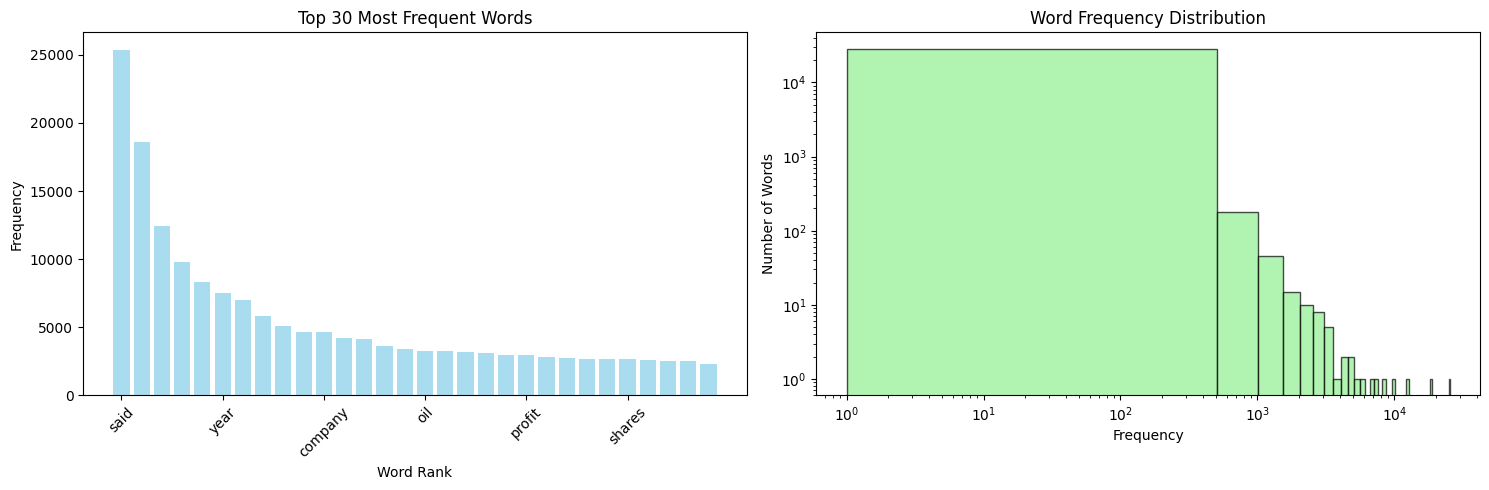

In [48]:
most_frequent_words = [word for word, count in vocab_counter.most_common(30)]
print("Top 30 most frequent words:")
for i, (word, count) in enumerate(vocab_counter.most_common(30), 1):
    print(f"{i:2d}. {word:<15} ({count:,} occurrences)")

# Visualize word frequency
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
words, counts = zip(*vocab_counter.most_common(30))
plt.bar(range(len(words)), counts, color='skyblue', alpha=0.7)
plt.title('Top 30 Most Frequent Words')
plt.xlabel('Word Rank')
plt.ylabel('Frequency')
plt.xticks(range(0, len(words), 5), [words[i] for i in range(0, len(words), 5)], rotation=45)

plt.subplot(1, 2, 2)
all_counts = list(vocab_counter.values())
plt.hist(all_counts, bins=50, alpha=0.7, color='lightgreen', edgecolor='black')
plt.title('Word Frequency Distribution')
plt.xlabel('Frequency')
plt.ylabel('Number of Words')
plt.yscale('log')
plt.xscale('log')

plt.tight_layout()
plt.show()


# Step 5: Word2Vec Model Training

In [49]:
def train_word2vec_models(sentences):
    """Train both Skip-gram and CBOW models"""
    print("Training Word2Vec models...")

    common_params = {
        'vector_size': 100,
        'window': 5,
        'min_count': 5,
        'workers': 4,
        'epochs': 10,
        'seed': 42
    }

    # Train Skip-gram
    print("\nTraining Skip-gram model...")
    start_time = time.time()
    skipgram_model = Word2Vec(sentences=sentences, sg=1, **common_params)
    skipgram_time = time.time() - start_time
    print(f"Skip-gram completed in {skipgram_time:.2f} seconds")

    # Train CBOW
    print("\nTraining CBOW model...")
    start_time = time.time()
    cbow_model = Word2Vec(sentences=sentences, sg=0, **common_params)
    cbow_time = time.time() - start_time
    print(f"CBOW completed in {cbow_time:.2f} seconds")

    stats = {
        'skipgram_vocab_size': len(skipgram_model.wv.key_to_index),
        'cbow_vocab_size': len(cbow_model.wv.key_to_index),
        'skipgram_training_time': skipgram_time,
        'cbow_training_time': cbow_time,
        'embedding_dim': common_params['vector_size'],
        'window_size': common_params['window']
    }

    print(f"\nModel Statistics:")
    print(f"  Skip-gram vocabulary: {stats['skipgram_vocab_size']:,}")
    print(f"  CBOW vocabulary: {stats['cbow_vocab_size']:,}")
    print(f"  Embedding dimension: {stats['embedding_dim']}")

    return skipgram_model, cbow_model, stats

# Train models
skipgram_model, cbow_model, training_stats = train_word2vec_models(sentences)


Training Word2Vec models...

Training Skip-gram model...
Skip-gram completed in 54.95 seconds

Training CBOW model...
CBOW completed in 16.01 seconds

Model Statistics:
  Skip-gram vocabulary: 10,137
  CBOW vocabulary: 10,137
  Embedding dimension: 100


# Step 6: Word Similarity Evaluation

In [51]:
def evaluate_word_similarity(skipgram_model, cbow_model):
    print("Evaluating word similarity...")

    similarity_tests = [
        ('king', 'queen'), ('man', 'woman'), ('company', 'business'),
        ('government', 'political'), ('market', 'economic'), ('bank', 'financial')
    ]

    results = {'skipgram': [], 'cbow': []}

    print(f"\n Word Similarity Comparisons:")
    print(f"{'Word Pair':<20} {'Skip-gram':<12} {'CBOW':<12} {'Difference':<12}")
    print("-" * 60)

    for word1, word2 in similarity_tests:
        try:
            # Skip-gram similarity
            if word1 in skipgram_model.wv and word2 in skipgram_model.wv:
                vec1_sg = skipgram_model.wv[word1]
                vec2_sg = skipgram_model.wv[word2]
                sg_sim = cosine_similarity_custom(vec1_sg, vec2_sg)  # From Q2
            else:
                sg_sim = None

            # CBOW similarity
            if word1 in cbow_model.wv and word2 in cbow_model.wv:
                vec1_cbow = cbow_model.wv[word1]
                vec2_cbow = cbow_model.wv[word2]
                cbow_sim = cosine_similarity_custom(vec1_cbow, vec2_cbow)  # From Q2
            else:
                cbow_sim = None

            if sg_sim is not None and cbow_sim is not None:
                diff = abs(sg_sim - cbow_sim)
                results['skipgram'].append(sg_sim)
                results['cbow'].append(cbow_sim)
                print(f"{word1}-{word2:<15} {sg_sim:<12.3f} {cbow_sim:<12.3f} {diff:<12.3f}")
            else:
                print(f"{word1}-{word2:<15} {'Missing':<12} {'Missing':<12} {'N/A':<12}")

        except Exception:
            print(f"{word1}-{word2:<15} {'Error':<12} {'Error':<12} {'N/A':<12}")

    return results

# Evaluate similarity
similarity_results = evaluate_word_similarity(skipgram_model, cbow_model)


Evaluating word similarity...

 Word Similarity Comparisons:
Word Pair            Skip-gram    CBOW         Difference  
------------------------------------------------------------
king-queen           0.372        0.423        0.051       
man-woman           Missing      Missing      N/A         
company-business        0.352        0.206        0.146       
government-political       0.475        0.311        0.164       
market-economic        0.305        0.133        0.172       
bank-financial       0.277        0.307        0.030       


# Step 7: Analogy Task Evaluation

In [94]:
def evaluate_analogies(skipgram_model, cbow_model):
    """Evaluate analogies using both Word2Vec built-in and custom methods"""
    print("Evaluating analogy performance...")

    analogy_tests = [
        # Financial/Business analogies more suitable for Reuters corpus
        ('banking', 'bank', 'trade', 'trading'),
        ('companies','company', 'market', 'markets'),
        ('dollars', 'dollar', 'share', 'shares'),
        ('governmental','government', 'economy', 'economic'),
        ('investment','invest', 'develop', 'development'),
        ('selling','sell', 'buy', 'buying')
    ]

    results = {'skipgram': [], 'cbow': []}

    print(f"\nAnalogy Task Results (Word2Vec built-in):")
    print(f"{'Analogy':<25} {'Skip-gram':<15} {'CBOW':<15} {'Expected':<10}")
    print("-" * 70)

    for word_a, word_b, word_c, expected in analogy_tests:
        # Skip-gram analogy (Correct formula: word_b - word_a + word_c)
        try:
            if all(word in skipgram_model.wv for word in [word_a, word_b, word_c]):
                sg_result = skipgram_model.wv.most_similar(positive=[word_a, word_c], negative=[word_b], topn=1)[0]
                sg_top_word = sg_result[0]
            else:
                sg_top_word = "Missing"
        except:
            sg_top_word = "Error"

        # CBOW analogy (Correct formula: word_b - word_a + word_c)
        try:
            if all(word in cbow_model.wv for word in [word_a, word_b, word_c]):
                cbow_result = cbow_model.wv.most_similar(positive=[word_a, word_c], negative=[word_b], topn=1)[0]
                cbow_top_word = cbow_result[0]
            else:
                cbow_top_word = "Missing"
        except:
            cbow_top_word = "Error"

        analogy_desc = f"{word_a}-{word_b}+{word_c}"
        print(f"{analogy_desc:<25} {sg_top_word:<15} {cbow_top_word:<15} {expected:<10}")

        results['skipgram'].append({
            'analogy': analogy_desc,
            'result': sg_top_word,
            'expected': expected,
            'correct': sg_top_word.lower() == expected.lower()
        })

        results['cbow'].append({
            'analogy': analogy_desc,
            'result': cbow_top_word,
            'expected': expected,
            'correct': cbow_top_word.lower() == expected.lower()
        })

    # Custom analogy evaluation using solve_analogy() from Question 2
    print(f"\nCustom Analogy Evaluation (using solve_analogy from Q2):")

    def model_to_dict(model):
        return {word: model.wv[word] for word in model.wv.key_to_index}

    sg_word_to_vec = model_to_dict(skipgram_model)
    cbow_word_to_vec = model_to_dict(cbow_model)

    for word_a, word_b, word_c, expected in analogy_tests:
        # Skip-gram evaluation using solve_analogy from Q2
        print("Skip-gram results:")
        sg_success, sg_results, _ = solve_analogy(word_a, word_b, word_c, sg_word_to_vec, top_k=3)

        # CBOW evaluation using solve_analogy from Q2
        print("CBOW results:")
        cbow_success, cbow_results, _ = solve_analogy(word_a, word_b, word_c, cbow_word_to_vec, top_k=3)

    return results

# Evaluate analogies
analogy_results = evaluate_analogies(skipgram_model, cbow_model)


Evaluating analogy performance...

 Analogy Task Results (Word2Vec built-in):
Analogy                   Skip-gram       CBOW            Expected  
----------------------------------------------------------------------
banking-bank+trade        israeli         willy           trading   
companies-company+market  markets         markets         markets   
dollars-dollar+share      dlrs            valued          shares    
governmental-government+economy maekawa         cites           economic  
investment-invest+develop weighing        climate         development
selling-sell+buy          buying          buying          buying    

Custom Analogy Evaluation (using solve_analogy from Q2):
Skip-gram results:
Formula: banking - bank + trade
Top 3 results:
 1. israeli         (similarity: 0.4917)
 2. testifying      (similarity: 0.4717)
 3. outlining       (similarity: 0.4688)
CBOW results:
Formula: banking - bank + trade
Top 3 results:
 1. challenge       (similarity: 0.5093)
 2. clercq  

# Step 8: PCA Visualization

Creating PCA visualizations...
Visualizing 30 words


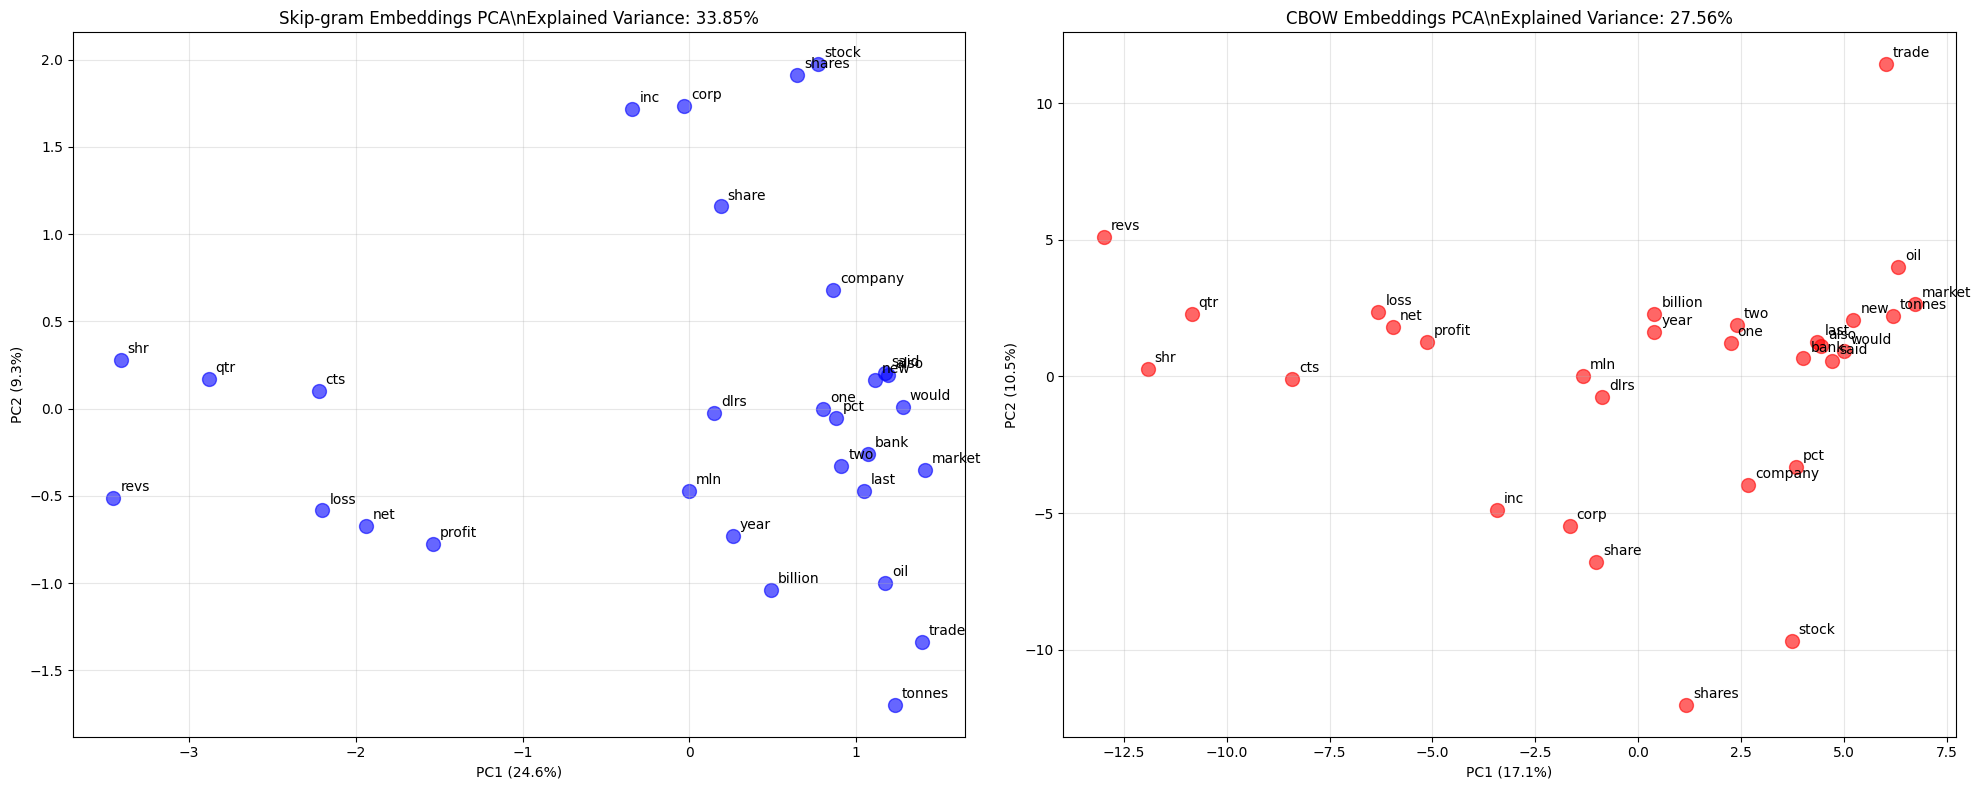

In [86]:
def visualize_embeddings_pca(skipgram_model, cbow_model, words_to_plot):
    print("Creating PCA visualizations...")

    valid_words = [word for word in words_to_plot
                   if word in skipgram_model.wv and word in cbow_model.wv]

    if len(valid_words) < 10:
        print(f" Only {len(valid_words)} words available")
        return

    print(f"Visualizing {len(valid_words)} words")

    # Get embeddings
    sg_embeddings = np.array([skipgram_model.wv[word] for word in valid_words])
    cbow_embeddings = np.array([cbow_model.wv[word] for word in valid_words])

    # Apply PCA
    pca_sg = PCA(n_components=2, random_state=42)
    sg_pca = pca_sg.fit_transform(sg_embeddings)

    pca_cbow = PCA(n_components=2, random_state=42)
    cbow_pca = pca_cbow.fit_transform(cbow_embeddings)

    # Create visualization
    fig, axes = plt.subplots(1, 2, figsize=(20, 8))

    # Skip-gram plot
    axes[0].scatter(sg_pca[:, 0], sg_pca[:, 1], c='blue', alpha=0.6, s=100)
    for i, word in enumerate(valid_words):
        axes[0].annotate(word, (sg_pca[i, 0], sg_pca[i, 1]), xytext=(5, 5),
                        textcoords='offset points', fontsize=10, ha='left')
    axes[0].set_title(f'Skip-gram Embeddings PCA\\nExplained Variance: {pca_sg.explained_variance_ratio_.sum():.2%}')
    axes[0].set_xlabel(f'PC1 ({pca_sg.explained_variance_ratio_[0]:.1%})')
    axes[0].set_ylabel(f'PC2 ({pca_sg.explained_variance_ratio_[1]:.1%})')
    axes[0].grid(True, alpha=0.3)

    # CBOW plot
    axes[1].scatter(cbow_pca[:, 0], cbow_pca[:, 1], c='red', alpha=0.6, s=100)
    for i, word in enumerate(valid_words):
        axes[1].annotate(word, (cbow_pca[i, 0], cbow_pca[i, 1]), xytext=(5, 5),
                        textcoords='offset points', fontsize=10, ha='left')
    axes[1].set_title(f'CBOW Embeddings PCA\\nExplained Variance: {pca_cbow.explained_variance_ratio_.sum():.2%}')
    axes[1].set_xlabel(f'PC1 ({pca_cbow.explained_variance_ratio_[0]:.1%})')
    axes[1].set_ylabel(f'PC2 ({pca_cbow.explained_variance_ratio_[1]:.1%})')
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    return valid_words

# Create PCA visualization
visualized_words = visualize_embeddings_pca(skipgram_model, cbow_model, most_frequent_words)

# Step 9: Model Comparison Analysis


 Word Similarity Performance:
  Skip-gram average: 0.356
  CBOW average: 0.276
  Difference: 0.080

 Analogy Task Performance:
  Skip-gram: 2/6 (33.3%)
  CBOW: 2/6 (33.3%)

 Training Efficiency:
  Skip-gram: 54.95 seconds
  CBOW: 16.01 seconds


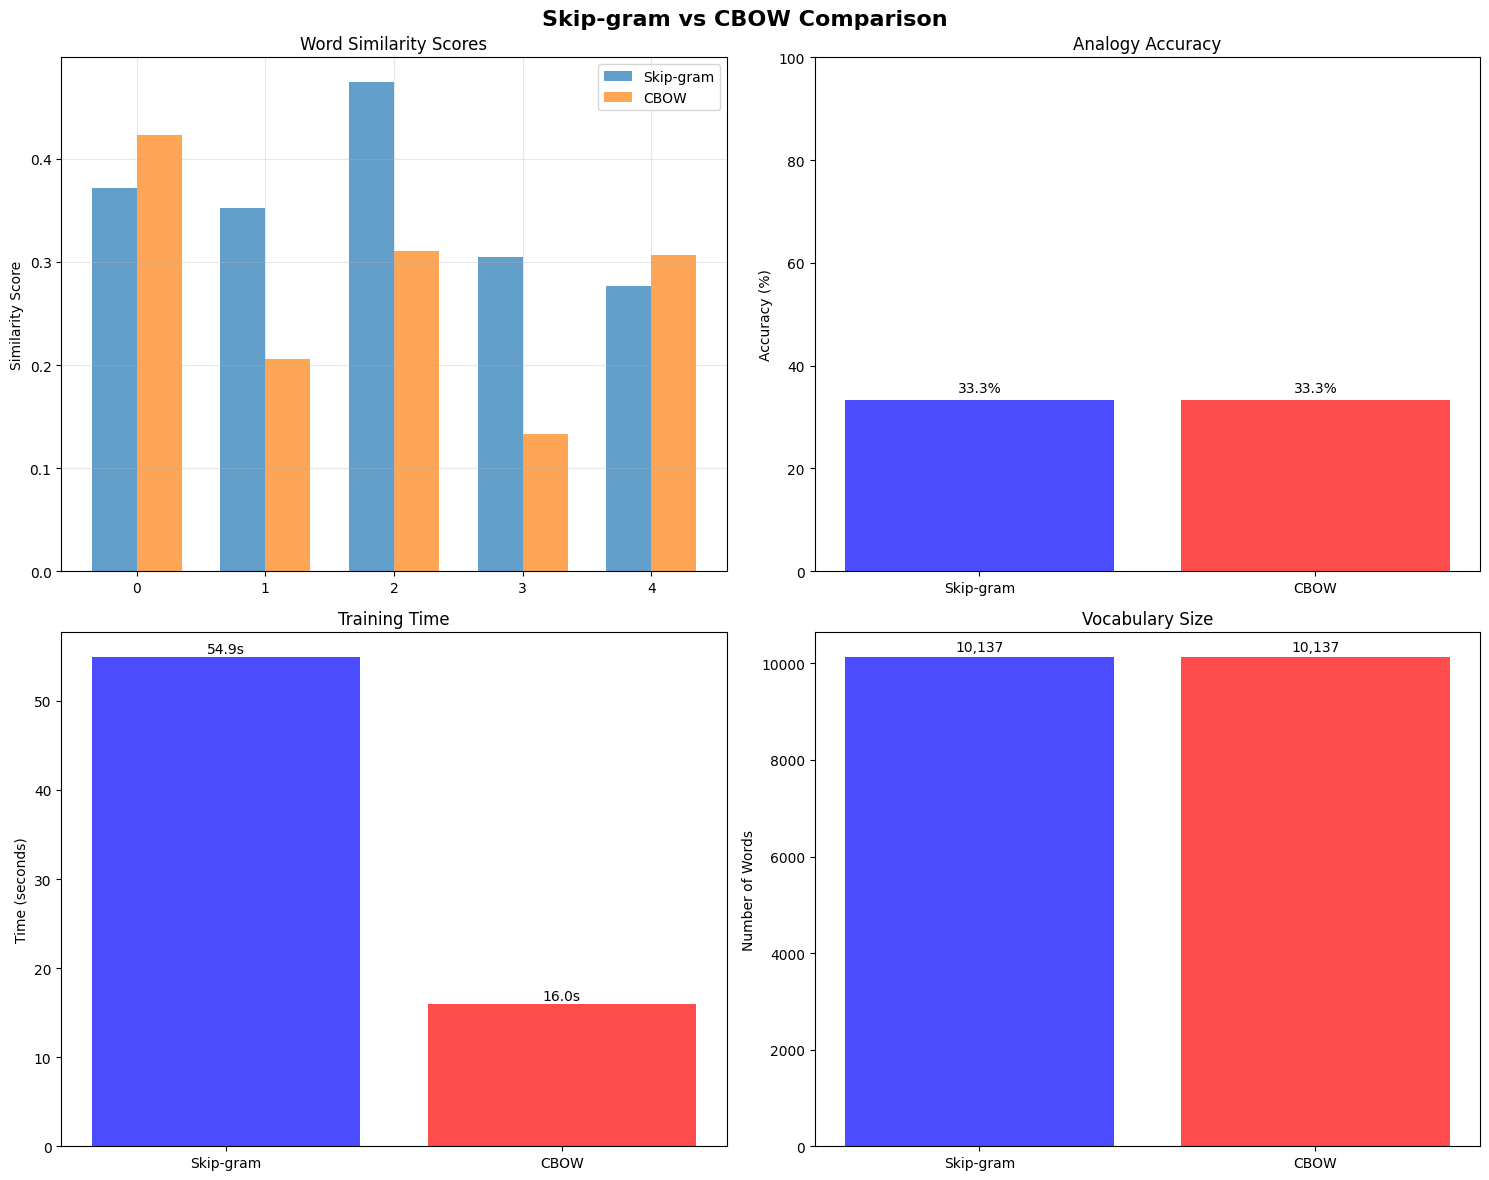

In [87]:
def compare_models(similarity_results, analogy_results):

    # Similarity comparison
    if similarity_results['skipgram'] and similarity_results['cbow']:
        sg_avg_sim = np.mean(similarity_results['skipgram'])
        cbow_avg_sim = np.mean(similarity_results['cbow'])

        print(f"\n Word Similarity Performance:")
        print(f"  Skip-gram average: {sg_avg_sim:.3f}")
        print(f"  CBOW average: {cbow_avg_sim:.3f}")
        print(f"  Difference: {abs(sg_avg_sim - cbow_avg_sim):.3f}")

    # Analogy comparison
    sg_correct = sum(1 for result in analogy_results['skipgram'] if result['correct'])
    cbow_correct = sum(1 for result in analogy_results['cbow'] if result['correct'])
    total_analogies = len(analogy_results['skipgram'])

    print(f"\n Analogy Task Performance:")
    print(f"  Skip-gram: {sg_correct}/{total_analogies} ({sg_correct/total_analogies*100:.1f}%)")
    print(f"  CBOW: {cbow_correct}/{total_analogies} ({cbow_correct/total_analogies*100:.1f}%)")

    # Training efficiency
    sg_time = training_stats['skipgram_training_time']
    cbow_time = training_stats['cbow_training_time']

    print(f"\n Training Efficiency:")
    print(f"  Skip-gram: {sg_time:.2f} seconds")
    print(f"  CBOW: {cbow_time:.2f} seconds")

    # Visualization
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Skip-gram vs CBOW Comparison', fontsize=16, fontweight='bold')

    # Similarity comparison
    if similarity_results['skipgram'] and similarity_results['cbow']:
        ax1 = axes[0, 0]
        x = np.arange(len(similarity_results['skipgram']))
        width = 0.35

        ax1.bar(x - width/2, similarity_results['skipgram'], width, label='Skip-gram', alpha=0.7)
        ax1.bar(x + width/2, similarity_results['cbow'], width, label='CBOW', alpha=0.7)
        ax1.set_title('Word Similarity Scores')
        ax1.set_ylabel('Similarity Score')
        ax1.legend()
        ax1.grid(True, alpha=0.3)

    # Analogy accuracy
    ax2 = axes[0, 1]
    models = ['Skip-gram', 'CBOW']
    accuracies = [sg_correct/total_analogies*100, cbow_correct/total_analogies*100]
    colors = ['blue', 'red']

    bars = ax2.bar(models, accuracies, color=colors, alpha=0.7)
    ax2.set_title('Analogy Accuracy')
    ax2.set_ylabel('Accuracy (%)')
    ax2.set_ylim(0, 100)

    for bar, acc in zip(bars, accuracies):
        ax2.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 1,
                f'{acc:.1f}%', ha='center', va='bottom')

    # Training time
    ax3 = axes[1, 0]
    training_times = [sg_time, cbow_time]
    bars = ax3.bar(models, training_times, color=colors, alpha=0.7)
    ax3.set_title('Training Time')
    ax3.set_ylabel('Time (seconds)')

    for bar, time_val in zip(bars, training_times):
        ax3.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.1,
                f'{time_val:.1f}s', ha='center', va='bottom')

    # Vocabulary size
    ax4 = axes[1, 1]
    vocab_sizes = [training_stats['skipgram_vocab_size'], training_stats['cbow_vocab_size']]
    bars = ax4.bar(models, vocab_sizes, color=colors, alpha=0.7)
    ax4.set_title('Vocabulary Size')
    ax4.set_ylabel('Number of Words')

    for bar, vocab_size in zip(bars, vocab_sizes):
        ax4.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 50,
                f'{vocab_size:,}', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

# Run comparison
compare_models(similarity_results, analogy_results)

# Step 10: Final Summary

In [93]:
print(f" Reuters Corpus Analysis:")
print(f"  Documents processed: {corpus_stats['documents']:,}")
print(f"  Vocabulary size: {corpus_stats['unique_tokens']:,}")

print(f"\n Model Training:")
print(f"  Skip-gram vocabulary: {training_stats['skipgram_vocab_size']:,}")
print(f"  CBOW vocabulary: {training_stats['cbow_vocab_size']:,}")

sg_correct = sum(1 for result in analogy_results['skipgram'] if result['correct'])
cbow_correct = sum(1 for result in analogy_results['cbow'] if result['correct'])
total_analogies = len(analogy_results['skipgram'])

if similarity_results['skipgram'] and similarity_results['cbow']:
    sg_avg_sim = np.mean(similarity_results['skipgram'])
    cbow_avg_sim = np.mean(similarity_results['cbow'])

    print(f"\n Word Similarity Performance:")
    print(f"  Skip-gram average: {sg_avg_sim:.3f}")
    print(f"  CBOW average: {cbow_avg_sim:.3f}")
    print(f"  Difference: {abs(sg_avg_sim - cbow_avg_sim):.3f}")
print(f"\n Analogy Performance:")
print(f"  Skip-gram analogy accuracy: {sg_correct/total_analogies*100:.1f}%")
print(f"  CBOW analogy accuracy: {cbow_correct/total_analogies*100:.1f}%")

print(f"\n Insights:")
print(f"1. Both models learned word representations from Reuters corpus")

#Which model performed better on word similarity
if sg_avg_sim > cbow_avg_sim:
    better_similarity = "Skip-gram"
elif sg_avg_sim < cbow_avg_sim:
    better_similarity = "CBOW"
else:
    better_similarity = "Both performed equally"

print(f"2. {better_similarity} performed better on word similarity")
#Which model performed better on analogies
if sg_correct > cbow_correct:
    better_model = "Skip-gram"
elif sg_correct < cbow_correct:
    better_model = "CBOW"
else:
    better_model = "Both performed equally"

print(f"3. {better_model} performed better on analogies")

# Which model was faster to train
if training_stats['cbow_training_time'] < training_stats['skipgram_training_time']:
    faster_model = "CBOW"
elif training_stats['cbow_training_time'] > training_stats['skipgram_training_time']:
    faster_model = "Skip-gram"
else:
    faster_model = "Both trained in the same time"

print(f"4. {faster_model} was faster to train")

# PCA result
print(f"5. PCA shows semantic clustering of related words")




 Reuters Corpus Analysis:
  Documents processed: 10,727
  Vocabulary size: 28,722

 Model Training:
  Skip-gram vocabulary: 10,137
  CBOW vocabulary: 10,137

 Word Similarity Performance:
  Skip-gram average: 0.356
  CBOW average: 0.276
  Difference: 0.080

 Analogy Performance:
  Skip-gram analogy accuracy: 33.3%
  CBOW analogy accuracy: 33.3%

 Insights:
1. Both models learned word representations from Reuters corpus
2. Skip-gram performed better on word similarity
3. Both performed equally performed better on analogies
4. CBOW was faster to train
5. PCA shows semantic clustering of related words
